In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we will use **AlexNet/VGG-16/ResNet** architecture (pretrained on [ImageNet-1K](https://www.image-net.org/)) for classifying images from CIFAR10 dataset. In particular, we won't train the whole network on CIFAR10 dataset, instead we will only train the final few layers of the network, and for the rest layers we will use the pretrained weights. This way on training a network is known as transfer learning. 

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<br/>
    <img src='../images/cifar_data.png' width=50% height=50% />
<br/>

### Loading CIFAR10 dataset into train-val-test set

In [2]:
import torchvision.transforms as transforms 
import torchvision.datasets as datasets

**train-test-transform**

Note: Since, we will be using pretrained CNNs for classifying CIFAR10 images, we have to resize the images to $224 \times 224$, instaead of $32 \times 32$.

In [3]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=test_transform)

test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Separating train-set into train & validation set**
- Let's set validation set size as 20%, therefore, we will be using 80% of training set for training 
    the neural network
- Validating a model while training w.r.t a validation-set can help us from overfitting
- Validation-set works as an alternative to the actual test-set, as it is assumed that while training 
    we do not have any access to the test-set 

In [5]:
train_set_size = len(train_dataset)
print('train-set-size: {}'.format(train_set_size))

train-set-size: 50000


In [6]:
import numpy as np

all_indices = list(range(train_set_size))
print('len(all_indices): '.format(len(all_indices)))

np.random.shuffle(all_indices)

val_size = int(0.2 * len(all_indices))
train_size = len(all_indices) - val_size
print('val-size: {} train-size: {}'.format(val_size, train_size))

val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

print('len(train_indices): {} len(val_indices): {}'.format(len(train_indices), len(val_indices)))

len(all_indices): 
val-size: 10000 train-size: 40000
len(train_indices): 40000 len(val_indices): 10000


In [7]:
from torch.utils.data import SubsetRandomSampler
import torch

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           sampler=SubsetRandomSampler(train_indices), num_workers=4, 
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        sampler=SubsetRandomSampler(val_indices), num_workers=4,
                                        pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [9]:
train_data, train_targets = next(iter(train_loader))
val_data, val_targets = next(iter(val_loader))
test_data, test_targets = next(iter(test_loader))

In [10]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
import matplotlib.pyplot as plt

### Visualize a Batch of Training Data

In [12]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

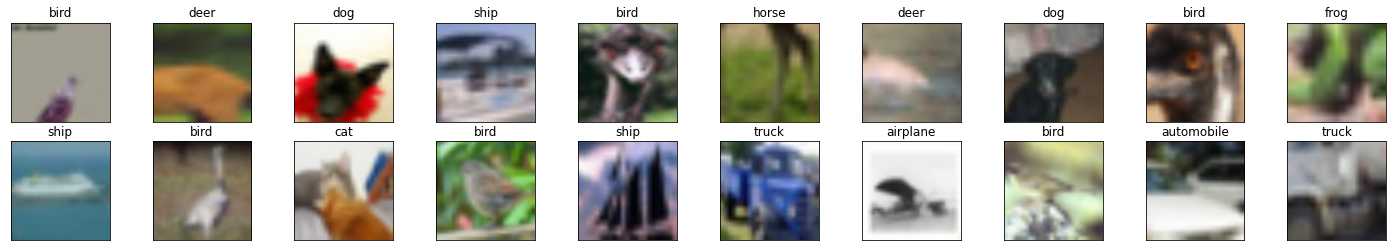

In [13]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(train_data[idx])
    ax.set_title(classes[train_targets[idx]])

### Visualize a Batch of Validation Data

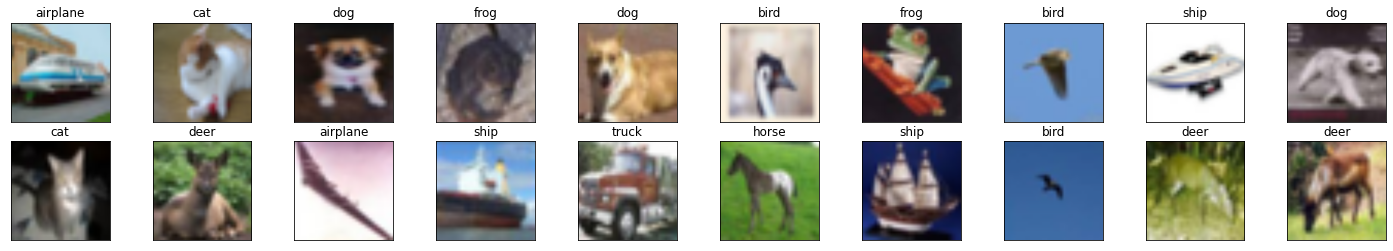

In [14]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(val_data[idx])
    ax.set_title(classes[val_targets[idx]])

### Visualize a Batch of Test Data

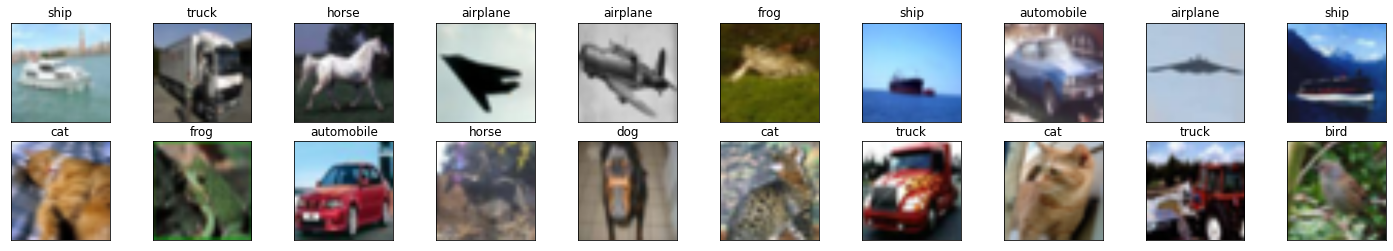

In [15]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(test_data[idx])
    ax.set_title(classes[test_targets[idx]])

In [16]:
!python --version

Python 3.7.7


## CNN training

In [17]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import time
import torch.optim as optim

from typing import Tuple, Any, List

def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

# ResNet-18 (pretrained)

In [20]:
from torchvision.models import resnet18
import torchvision
print(torch.__version__)
print(torchvision.__version__)



1.7.0.dev20200813
0.8.0.dev20200813


In [21]:
model = resnet18(pretrained=True) # use pretrained weights
print(model)

for _, param in model.named_parameters():
    param.requires_grad = False # we are making sure, that during training, we do not optimize the 
                                # pretrained weights

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
in_features = model.fc.in_features

model.fc = nn.Linear(in_features=in_features, out_features=10) # changing the final layer to accomodate only 
                                                               # 10 classes, instead of 1000 classes

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's only train **layer4.1 and fc**, for the rest layer, we will simply use the pretrained weights, and won't optimize these parameters while optimizing. 

In [28]:
for _, param in model.layer4[1].named_parameters():
    param.requires_grad = True
for _, param in model.fc.named_parameters():
    param.requires_grad = True

Let's verify

In [29]:
for name, param in model.named_parameters():
    print('name: {} requires_grad: {}'.format(name, param.requires_grad))

name: conv1.weight requires_grad: False
name: bn1.weight requires_grad: False
name: bn1.bias requires_grad: False
name: layer1.0.conv1.weight requires_grad: False
name: layer1.0.bn1.weight requires_grad: False
name: layer1.0.bn1.bias requires_grad: False
name: layer1.0.conv2.weight requires_grad: False
name: layer1.0.bn2.weight requires_grad: False
name: layer1.0.bn2.bias requires_grad: False
name: layer1.1.conv1.weight requires_grad: False
name: layer1.1.bn1.weight requires_grad: False
name: layer1.1.bn1.bias requires_grad: False
name: layer1.1.conv2.weight requires_grad: False
name: layer1.1.bn2.weight requires_grad: False
name: layer1.1.bn2.bias requires_grad: False
name: layer2.0.conv1.weight requires_grad: False
name: layer2.0.bn1.weight requires_grad: False
name: layer2.0.bn1.bias requires_grad: False
name: layer2.0.conv2.weight requires_grad: False
name: layer2.0.bn2.weight requires_grad: False
name: layer2.0.bn2.bias requires_grad: False
name: layer2.0.downsample.0.weight requi

In [30]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, 
                                        checkpoint='pretrained_resnet18_cifar10_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.7875
Epoch: [1/100] train_acc: 0.5788 val_acc: 0.7875 train_loss: 1.2033 val_loss: 0.5962
Epoch: 2 val accuracy improved: 0.7875 ==> 0.8201
Epoch: [2/100] train_acc: 0.6574 val_acc: 0.8201 train_loss: 0.9735 val_loss: 0.5114
Epoch: 3 val accuracy improved: 0.8201 ==> 0.8301
Epoch: [3/100] train_acc: 0.6755 val_acc: 0.8301 train_loss: 0.9178 val_loss: 0.4844
Epoch: 4 val accuracy improved: 0.8301 ==> 0.8364
Epoch: [4/100] train_acc: 0.6903 val_acc: 0.8364 train_loss: 0.8806 val_loss: 0.4688
Epoch: 5 val accuracy improved: 0.8364 ==> 0.8475
Epoch: [5/100] train_acc: 0.6963 val_acc: 0.8475 train_loss: 0.8550 val_loss: 0.4326
Epoch: [6/100] train_acc: 0.7063 val_acc: 0.8465 train_loss: 0.8344 val_loss: 0.4349
Epoch: 7 val accuracy improved: 0.8475 ==> 0.8515
Epoch: [7/100] train_acc: 0.7210 val_acc: 0.8515 train_loss: 0.8053 val_loss: 0.4195
Epoch: 8 val accuracy improved: 0.8515 ==> 0.8593
Epoch: [8/100] train_acc: 0.7176 val_acc

Epoch: [82/100] train_acc: 0.8235 val_acc: 0.8953 train_loss: 0.5033 val_loss: 0.3242
Epoch: [83/100] train_acc: 0.8245 val_acc: 0.8919 train_loss: 0.5046 val_loss: 0.3353
Epoch: [84/100] train_acc: 0.8246 val_acc: 0.8930 train_loss: 0.5054 val_loss: 0.3391
Epoch: [85/100] train_acc: 0.8261 val_acc: 0.8956 train_loss: 0.4961 val_loss: 0.3223
Epoch: [86/100] train_acc: 0.8240 val_acc: 0.8929 train_loss: 0.5005 val_loss: 0.3279
Epoch: [87/100] train_acc: 0.8298 val_acc: 0.8947 train_loss: 0.4881 val_loss: 0.3297
Epoch: [88/100] train_acc: 0.8262 val_acc: 0.8980 train_loss: 0.4972 val_loss: 0.3240
Epoch: [89/100] train_acc: 0.8262 val_acc: 0.8956 train_loss: 0.4910 val_loss: 0.3262
Epoch: [90/100] train_acc: 0.8303 val_acc: 0.8937 train_loss: 0.4900 val_loss: 0.3364
Epoch: [91/100] train_acc: 0.8274 val_acc: 0.8972 train_loss: 0.4908 val_loss: 0.3219
Epoch: 92 val accuracy improved: 0.8988 ==> 0.8997
Epoch: [92/100] train_acc: 0.8292 val_acc: 0.8997 train_loss: 0.4924 val_loss: 0.3109
Epo

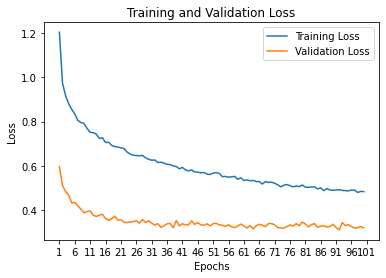

In [31]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

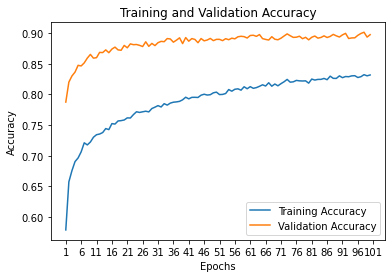

In [32]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

---
#### Test the Trained Network


In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model, DataParallel):
        model = DataParallel(model) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model.to(device) # load model to device

device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
# loading model's best saved weight
checkpoint = 'pretrained_resnet18_cifar10_best_model.pth'

try:
    model.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model.module.load_state_dict(torch.load(checkpoint, map_location=device))

In [35]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(64, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.3464

Test Accuracy of airplane: 88% (887/1000)
Test Accuracy of automobile: 94% (944/1000)
Test Accuracy of  bird: 86% (860/1000)
Test Accuracy of   cat: 76% (768/1000)
Test Accuracy of  deer: 89% (892/1000)
Test Accuracy of   dog: 81% (811/1000)
Test Accuracy of  frog: 93% (932/1000)
Test Accuracy of horse: 91% (919/1000)
Test Accuracy of  ship: 95% (957/1000)
Test Accuracy of truck: 94% (942/1000)

Test Accuracy (Overall): 89% (8912/10000)


### Visualize Sample Test Results

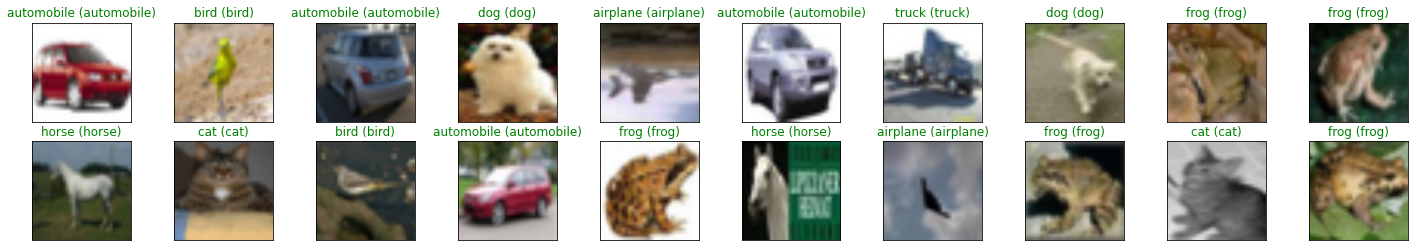

In [36]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not torch.cuda.is_available() else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# AlexNet (pretrained)

In [37]:
from torchvision.models import alexnet




In [38]:
model = alexnet(pretrained=True) # use pretrained weights
print(model)

for _, param in model.named_parameters():
    param.requires_grad = False # we are making sure, that during training, we do not optimize the 
                                # pretrained weights

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /users/gpu/soumyab/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [39]:
in_features = model.classifier[6].in_features

model.classifier[6] = nn.Linear(in_features=in_features, out_features=10) # changing the final layer to accomodate only 
                                                               # 10 classes, instead of 1000 classes

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Let's only train **classifier**, for the rest layer, we will simply use the pretrained weights, and won't optimize these parameters while optimizing. 

In [40]:
for _, param in model.classifier.named_parameters():
    param.requires_grad = True


Let's verify

In [41]:
for name, param in model.named_parameters():
    print('name: {} requires_grad: {}'.format(name, param.requires_grad))

name: features.0.weight requires_grad: False
name: features.0.bias requires_grad: False
name: features.3.weight requires_grad: False
name: features.3.bias requires_grad: False
name: features.6.weight requires_grad: False
name: features.6.bias requires_grad: False
name: features.8.weight requires_grad: False
name: features.8.bias requires_grad: False
name: features.10.weight requires_grad: False
name: features.10.bias requires_grad: False
name: classifier.1.weight requires_grad: True
name: classifier.1.bias requires_grad: True
name: classifier.4.weight requires_grad: True
name: classifier.4.bias requires_grad: True
name: classifier.6.weight requires_grad: True
name: classifier.6.bias requires_grad: True


In [42]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, 
                                        checkpoint='pretrained_alexnet_cifar10_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.7242
Epoch: [1/100] train_acc: 0.5101 val_acc: 0.7242 train_loss: 1.3606 val_loss: 0.7991
Epoch: 2 val accuracy improved: 0.7242 ==> 0.7558
Epoch: [2/100] train_acc: 0.5640 val_acc: 0.7558 train_loss: 1.2196 val_loss: 0.6901
Epoch: 3 val accuracy improved: 0.7558 ==> 0.7618
Epoch: [3/100] train_acc: 0.5819 val_acc: 0.7618 train_loss: 1.1699 val_loss: 0.6662
Epoch: 4 val accuracy improved: 0.7618 ==> 0.7746
Epoch: [4/100] train_acc: 0.5906 val_acc: 0.7746 train_loss: 1.1448 val_loss: 0.6355
Epoch: 5 val accuracy improved: 0.7746 ==> 0.7797
Epoch: [5/100] train_acc: 0.6036 val_acc: 0.7797 train_loss: 1.1144 val_loss: 0.6201
Epoch: 6 val accuracy improved: 0.7797 ==> 0.7838
Epoch: [6/100] train_acc: 0.6085 val_acc: 0.7838 train_loss: 1.0932 val_loss: 0.6077
Epoch: 7 val accuracy improved: 0.7838 ==> 0.7853
Epoch: [7/100] train_acc: 0.6113 val_acc: 0.7853 train_loss: 1.0853 val_loss: 0.6098
Epoch: 8 val accuracy improved: 0.7853 =

Epoch: [80/100] train_acc: 0.6913 val_acc: 0.8463 train_loss: 0.8680 val_loss: 0.4357
Epoch: [81/100] train_acc: 0.6915 val_acc: 0.8420 train_loss: 0.8637 val_loss: 0.4529
Epoch: 82 val accuracy improved: 0.8503 ==> 0.8529
Epoch: [82/100] train_acc: 0.6942 val_acc: 0.8529 train_loss: 0.8604 val_loss: 0.4245
Epoch: [83/100] train_acc: 0.6921 val_acc: 0.8496 train_loss: 0.8640 val_loss: 0.4424
Epoch: [84/100] train_acc: 0.6921 val_acc: 0.8489 train_loss: 0.8615 val_loss: 0.4328
Epoch: 85 val accuracy improved: 0.8529 ==> 0.8541
Epoch: [85/100] train_acc: 0.6926 val_acc: 0.8541 train_loss: 0.8652 val_loss: 0.4248
Epoch: [86/100] train_acc: 0.6918 val_acc: 0.8490 train_loss: 0.8612 val_loss: 0.4329
Epoch: [87/100] train_acc: 0.6955 val_acc: 0.8495 train_loss: 0.8606 val_loss: 0.4330
Epoch: [88/100] train_acc: 0.6964 val_acc: 0.8465 train_loss: 0.8552 val_loss: 0.4480
Epoch: [89/100] train_acc: 0.6955 val_acc: 0.8530 train_loss: 0.8535 val_loss: 0.4274
Epoch: [90/100] train_acc: 0.6941 val_

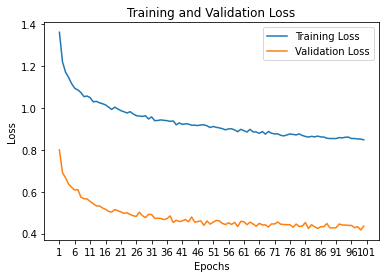

In [43]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

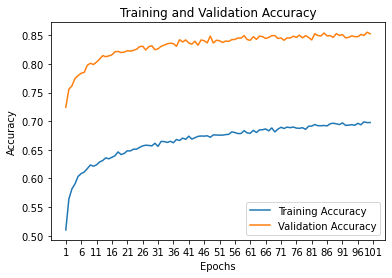

In [44]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

---
#### Test the Trained Network


In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model, DataParallel):
        model = DataParallel(model) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model.to(device) # load model to device

device: cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [46]:
# loading model's best saved weight
checkpoint = 'pretrained_alexnet_cifar10_best_model.pth'

try:
    model.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model.module.load_state_dict(torch.load(checkpoint, map_location=device))

In [47]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(64, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.4279

Test Accuracy of airplane: 88% (880/1000)
Test Accuracy of automobile: 91% (918/1000)
Test Accuracy of  bird: 85% (850/1000)
Test Accuracy of   cat: 67% (674/1000)
Test Accuracy of  deer: 84% (846/1000)
Test Accuracy of   dog: 73% (731/1000)
Test Accuracy of  frog: 91% (911/1000)
Test Accuracy of horse: 88% (882/1000)
Test Accuracy of  ship: 92% (921/1000)
Test Accuracy of truck: 92% (922/1000)

Test Accuracy (Overall): 85% (8535/10000)


### Visualize Sample Test Results

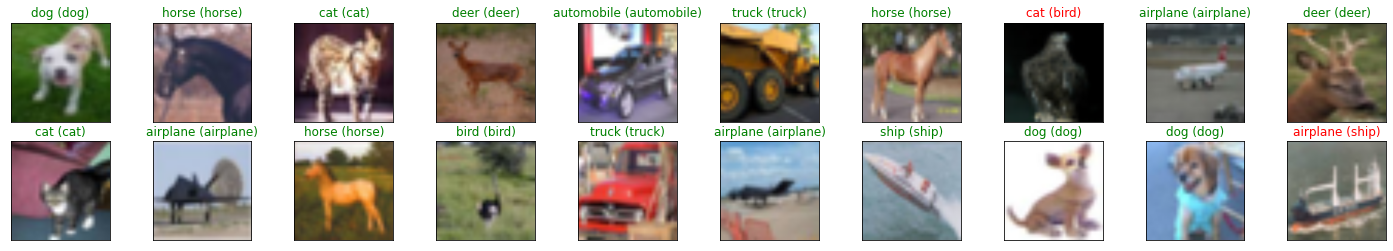

In [48]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not torch.cuda.is_available() else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# VGG-16 (pretrained)

In [49]:
from torchvision.models import vgg16




In [50]:
model = vgg16(pretrained=True) # use pretrained weights
print(model)

for _, param in model.named_parameters():
    param.requires_grad = False # we are making sure, that during training, we do not optimize the 
                                # pretrained weights

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [51]:
in_features = model.classifier[6].in_features

model.classifier[6] = nn.Linear(in_features=in_features, out_features=10) # changing the final layer to accomodate only 
                                                               # 10 classes, instead of 1000 classes

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Let's only train **classifier**, for the rest layer, we will simply use the pretrained weights, and won't optimize these parameters while optimizing. 

In [52]:
for _, param in model.classifier.named_parameters():
    param.requires_grad = True


Let's verify

In [53]:
for name, param in model.named_parameters():
    print('name: {} requires_grad: {}'.format(name, param.requires_grad))

name: features.0.weight requires_grad: False
name: features.0.bias requires_grad: False
name: features.2.weight requires_grad: False
name: features.2.bias requires_grad: False
name: features.5.weight requires_grad: False
name: features.5.bias requires_grad: False
name: features.7.weight requires_grad: False
name: features.7.bias requires_grad: False
name: features.10.weight requires_grad: False
name: features.10.bias requires_grad: False
name: features.12.weight requires_grad: False
name: features.12.bias requires_grad: False
name: features.14.weight requires_grad: False
name: features.14.bias requires_grad: False
name: features.17.weight requires_grad: False
name: features.17.bias requires_grad: False
name: features.19.weight requires_grad: False
name: features.19.bias requires_grad: False
name: features.21.weight requires_grad: False
name: features.21.bias requires_grad: False
name: features.24.weight requires_grad: False
name: features.24.bias requires_grad: False
name: features.26.

In [54]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, 
                                        checkpoint='pretrained_vgg16_cifar10_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.7774
Epoch: [1/100] train_acc: 0.5464 val_acc: 0.7774 train_loss: 1.2668 val_loss: 0.6201
Epoch: 2 val accuracy improved: 0.7774 ==> 0.8071
Epoch: [2/100] train_acc: 0.6077 val_acc: 0.8071 train_loss: 1.0918 val_loss: 0.5444
Epoch: 3 val accuracy improved: 0.8071 ==> 0.8207
Epoch: [3/100] train_acc: 0.6298 val_acc: 0.8207 train_loss: 1.0370 val_loss: 0.5112
Epoch: 4 val accuracy improved: 0.8207 ==> 0.8314
Epoch: [4/100] train_acc: 0.6412 val_acc: 0.8314 train_loss: 1.0036 val_loss: 0.4814
Epoch: 5 val accuracy improved: 0.8314 ==> 0.8375
Epoch: [5/100] train_acc: 0.6541 val_acc: 0.8375 train_loss: 0.9733 val_loss: 0.4656
Epoch: [6/100] train_acc: 0.6610 val_acc: 0.8339 train_loss: 0.9490 val_loss: 0.4712
Epoch: 7 val accuracy improved: 0.8375 ==> 0.8442
Epoch: [7/100] train_acc: 0.6671 val_acc: 0.8442 train_loss: 0.9357 val_loss: 0.4381
Epoch: 8 val accuracy improved: 0.8442 ==> 0.8491
Epoch: [8/100] train_acc: 0.6696 val_acc

Epoch: [78/100] train_acc: 0.7623 val_acc: 0.8869 train_loss: 0.6698 val_loss: 0.3471
Epoch: [79/100] train_acc: 0.7638 val_acc: 0.8890 train_loss: 0.6691 val_loss: 0.3507
Epoch: [80/100] train_acc: 0.7641 val_acc: 0.8875 train_loss: 0.6646 val_loss: 0.3428
Epoch: [81/100] train_acc: 0.7650 val_acc: 0.8904 train_loss: 0.6651 val_loss: 0.3428
Epoch: [82/100] train_acc: 0.7614 val_acc: 0.8895 train_loss: 0.6704 val_loss: 0.3392
Epoch: [83/100] train_acc: 0.7615 val_acc: 0.8892 train_loss: 0.6683 val_loss: 0.3440
Epoch: [84/100] train_acc: 0.7627 val_acc: 0.8864 train_loss: 0.6671 val_loss: 0.3476
Epoch: [85/100] train_acc: 0.7685 val_acc: 0.8899 train_loss: 0.6551 val_loss: 0.3481
Epoch: [86/100] train_acc: 0.7673 val_acc: 0.8881 train_loss: 0.6566 val_loss: 0.3478
Epoch: [87/100] train_acc: 0.7675 val_acc: 0.8877 train_loss: 0.6553 val_loss: 0.3532
Epoch: [88/100] train_acc: 0.7707 val_acc: 0.8848 train_loss: 0.6493 val_loss: 0.3544
Epoch: [89/100] train_acc: 0.7692 val_acc: 0.8873 trai

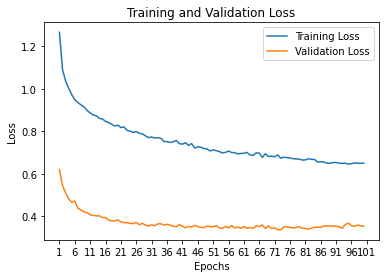

In [55]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

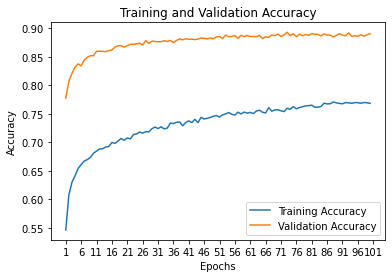

In [56]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

---
#### Test the Trained Network


In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model, DataParallel):
        model = DataParallel(model) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model.to(device) # load model to device

device: cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
# loading model's best saved weight
checkpoint = 'pretrained_vgg16_cifar10_best_model.pth'

try:
    model.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model.module.load_state_dict(torch.load(checkpoint, map_location=device))

In [59]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(64, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.3647

Test Accuracy of airplane: 92% (928/1000)
Test Accuracy of automobile: 94% (941/1000)
Test Accuracy of  bird: 83% (832/1000)
Test Accuracy of   cat: 73% (732/1000)
Test Accuracy of  deer: 89% (893/1000)
Test Accuracy of   dog: 84% (842/1000)
Test Accuracy of  frog: 91% (910/1000)
Test Accuracy of horse: 89% (898/1000)
Test Accuracy of  ship: 93% (937/1000)
Test Accuracy of truck: 92% (921/1000)

Test Accuracy (Overall): 88% (8834/10000)


### Visualize Sample Test Results

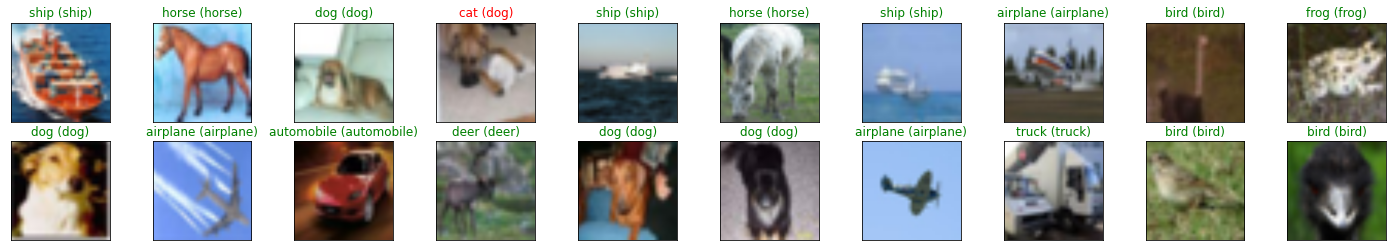

In [60]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not torch.cuda.is_available() else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))